In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

In [6]:
%matplotlib inline
import sys,os
import csv
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [19]:
#file names for max, min and median datasets
maxfile = '../../metop_rad_belt_max_vals_lagged_sw.csv'
print(os.path.exists(maxfile))
minfile = '../../metop_rad_belt_min_vals_lagged_sw.csv'
print(os.path.exists(maxfile))
medfile = '../../metop_rad_belt_median_vals_lagged_sw.csv'
print(os.path.exists(maxfile))

True
True
True


In [28]:
#read in and combine
maxset = pd.read_csv(maxfile).add_prefix('max_')
minset = pd.read_csv(minfile).add_prefix('min_')
medset = pd.read_csv(medfile).add_prefix('med_')

raw = pd.concat([maxset, minset, medset], axis=1)
print(raw.columns)

Index(['max_dateTime', 'max_Kp', 'max_Dst', 'max_dens', 'max_velo', 'max_Pdyn',
       'max_ByIMF', 'max_BzIMF', 'max_mep06', 'max_mep05',
       ...
       'med_ByIMF_lag4', 'med_ByIMF_lag5', 'med_ByIMF_lag6', 'med_BzIMF_lag0',
       'med_BzIMF_lag1', 'med_BzIMF_lag2', 'med_BzIMF_lag3', 'med_BzIMF_lag4',
       'med_BzIMF_lag5', 'med_BzIMF_lag6'],
      dtype='object', length=153)


In [42]:
#variables with lags
cols = ['min_ByIMF', 'min_BzIMF', 'max_Pdyn']
X_cols = []
for l in range(7):
    for nm in cols:
        X_cols.append(nm+'_lag'+str(l))
        
#variables w/o lags        
add_cols = ['min_Dst','max_Kp', 'med_Lval', 'med_mlt']
X_cols.extend(add_cols)
print(X_cols)    
Xs = raw[X_cols]

#compute momentum
for l in range(7):
    oo = 'max_moment_lag'+str(l)
    dens = 'max_dens_lag'+str(l)
    vv = 'max_velo_lag'+str(l)
    Xs[oo] = raw[dens]*raw[vv]
    
print(Xs.columns)

['min_ByIMF_lag0', 'min_BzIMF_lag0', 'max_Pdyn_lag0', 'min_ByIMF_lag1', 'min_BzIMF_lag1', 'max_Pdyn_lag1', 'min_ByIMF_lag2', 'min_BzIMF_lag2', 'max_Pdyn_lag2', 'min_ByIMF_lag3', 'min_BzIMF_lag3', 'max_Pdyn_lag3', 'min_ByIMF_lag4', 'min_BzIMF_lag4', 'max_Pdyn_lag4', 'min_ByIMF_lag5', 'min_BzIMF_lag5', 'max_Pdyn_lag5', 'min_ByIMF_lag6', 'min_BzIMF_lag6', 'max_Pdyn_lag6', 'min_Dst', 'max_Kp', 'med_Lval', 'med_mlt']
Index(['min_ByIMF_lag0', 'min_BzIMF_lag0', 'max_Pdyn_lag0', 'min_ByIMF_lag1',
       'min_BzIMF_lag1', 'max_Pdyn_lag1', 'min_ByIMF_lag2', 'min_BzIMF_lag2',
       'max_Pdyn_lag2', 'min_ByIMF_lag3', 'min_BzIMF_lag3', 'max_Pdyn_lag3',
       'min_ByIMF_lag4', 'min_BzIMF_lag4', 'max_Pdyn_lag4', 'min_ByIMF_lag5',
       'min_BzIMF_lag5', 'max_Pdyn_lag5', 'min_ByIMF_lag6', 'min_BzIMF_lag6',
       'max_Pdyn_lag6', 'min_Dst', 'max_Kp', 'med_Lval', 'med_mlt',
       'max_moment_lag0', 'max_moment_lag1', 'max_moment_lag2',
       'max_moment_lag3', 'max_moment_lag4', 'max_moment_lag5',

/opt/conda/envs/rapids/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [43]:
#target variable to predict
Y = raw.max_mep06

In [44]:
#split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xs, Y, test_size=0.2, random_state=43)

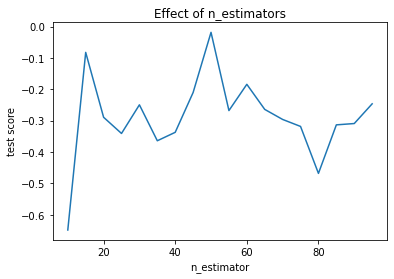

In [46]:
#check impact of n_trees to the model test score
from sklearn.ensemble import RandomForestRegressor

estimators = np.arange(10, 100, 5)
scores = []

rf = RandomForestRegressor(n_jobs=-1)

for n in estimators:
    rf.set_params(n_estimators=n)
    rf.fit(X_train, y_train)
    scores.append(rf.score(X_test, y_test))

plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("test score")
plt.plot(estimators, scores)

In [47]:
#functions for drop column importance 
from sklearn.base import clone 
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = imp_df(X_train.columns, importances)
    return importances_df

In [48]:
importance_df = drop_col_feat_imp(rf, X_train, y_train)

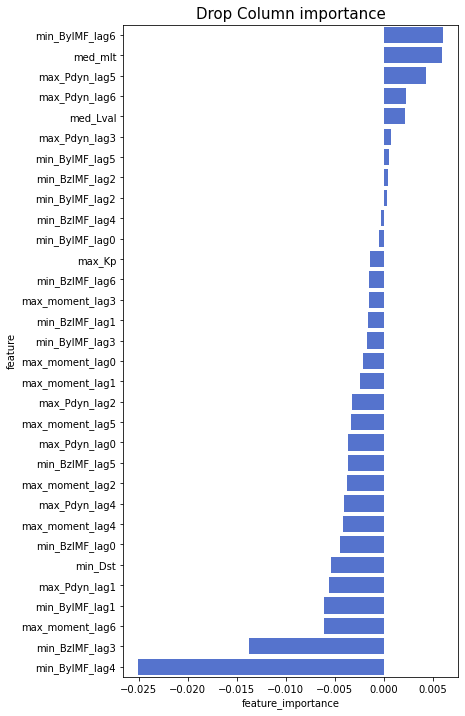

In [49]:
import seaborn as sns
# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 15)
plt.figure(figsize=(6,12))
var_imp_plot(importance_df, 'Drop Column importance')

In [50]:
#pick top 10 features
sel_cols = importance_df.feature[:10].values
print(sel_cols)

['min_ByIMF_lag6' 'med_mlt' 'max_Pdyn_lag5' 'max_Pdyn_lag6' 'med_Lval'
 'max_Pdyn_lag3' 'min_ByIMF_lag5' 'min_BzIMF_lag2' 'min_ByIMF_lag2'
 'min_BzIMF_lag4']


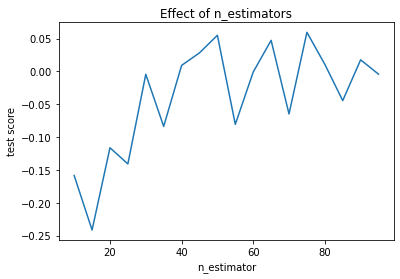

In [52]:
# re-train model with top 10 and show score vs n-trees
X_train, X_test, y_train, y_test = train_test_split(Xs[sel_cols], 
                 raw.max_mep06, test_size=0.2, random_state=43)

estimators = np.arange(10, 100, 5)
scores = []
rf = RandomForestRegressor(n_jobs=-1)

for n in estimators:
    rf.set_params(n_estimators=n)
    rf.fit(X_train, y_train)
    scores.append(rf.score(X_test, y_test))

plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("test score")
plt.plot(estimators, scores)

In [53]:
print(max(scores))

0.05946499936259264


In [56]:
#conduct Randomized Search to find the best model
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 16, num = 8)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [57]:
rf_new = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf_new, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, 
                               random_state=42, n_jobs = -1)
rf_random.fit(Xs[sel_cols], raw.max_mep06)
print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   28.1s


{'n_estimators': 70, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 2, 'bootstrap': True}


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   59.8s finished


In [59]:
print(rf_random.best_estimator_)

RandomForestRegressor(max_depth=2, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=70)


In [61]:
#compare base model vs best model
from sklearn import metrics
base_model = RandomForestRegressor(n_estimators = 10, random_state=42)
base_model.fit(X_train, y_train)
pred_test = base_model.predict(X_test)
mae = metrics.mean_absolute_error(y_test, pred_test)
print('benchmark model mae {:0.4f}'.format(mae))
best_random = rf_random.best_estimator_
pred_test = best_random.predict(X_test)
mae = metrics.mean_absolute_error(y_test, pred_test)
print('best model mae {:0.4f}'.format(mae))

benchmark model mae 0.9645
best model mae 0.7791
